In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
from atl_module.geospatial_utils.raster_interaction import (
    random_raster_gdf,
    subset_gebco,
)
from atl_module import GebcoUpscaler
from atl_module.kriging import krige_bathy
from atl_module.error_calc import raster_RMSE_blocked
from atl_module.kalman import gridded_kalman_update
from atl_module.geospatial_utils.raster_interaction import query_from_lines
import geopandas as gpd
import pandas as pd

In [3]:
site = "charlotteamalie"
truthraster_path = f"../data/test_sites/{site}/in-situ-dem/truth.vrt"
tracklines = gpd.read_file(f"../data/test_sites/{site}/tracklines/")

<AxesSubplot:>

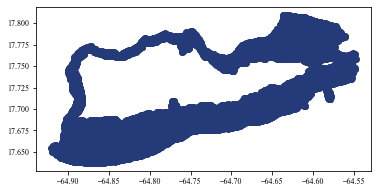

In [4]:
gdf = random_raster_gdf(truthraster_path, 40000)
gdf = gdf.rename(columns={"truth raster elevation": "sf_elev_MSL"})
gdf.plot()

In [5]:
gdf.to_file("../data/truthraster_sampling/random_pts.gpkg")
gdf = gdf.to_crs(gdf.estimate_utm_crs())

/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [6]:
gdf = gdf.rename(columns={"truth raster elevation": "sf_elev_MSL"})

In [7]:
hres = 50
subset_gebco(
    "../data/truthraster_sampling", bathy_pts=gdf, epsg_no=gdf.crs.to_epsg(), hres=hres
)

[D 220927 00:24:54 raster_interaction:149] GEBCO subset raster written to ../data/truthraster_sampling/bilinear.tif, with CRS EPSG:32620


In [8]:
# gdf = gdf.rename(columns={'truth raster elevation':'sf_elev_MSL'})

In [9]:
gdf = gdf[gdf.sf_elev_MSL < 0]

In [10]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show as rastershow

In [11]:
# with rasterio.open(truthraster_path) as femaras:
#     fig, ax = plt.subplots(figsize=(20, 12))
#     ax.set_xlabel(f"Degrees longitude in {femaras.crs}")
#     ax.set_ylabel(f"Degrees latitude in {femaras.crs}")
#     # ax.set_title("")
#     # cx.add_basemap(ax,source=cx.providers.OpenTopoMap,crs=femaras.crs)
#     image_hidden = ax.imshow(
#         femaras.read(1, masked=True),
#         cmap="inferno",
#     )
#     rastershow(femaras, cmap="inferno", ax=ax)

#     fig.colorbar(image_hidden, ax=ax)

# fig.savefig('../document/figures/truthraster_sampling_rasterplot.pdf',dpi=500,bbox_inches='tight')

In [12]:
krige_bathy(
    kr_model="uk",
    folderpath="../data/truthraster_sampling",
    npts=2000,
    variogram_model="spherical",
    pts_gdf_all=gdf,
    crs=gdf.crs,
    samplemethod="dart",
    variogram_parameters={"range": 10000, "nugget": 0.7, "sill": 23},
)
# .kriging(1500,kr_model='uk',samplemethod = 'dart')

[D 220927 00:24:54 kriging:29] The types of the numpy array that is sent to PDAL poisson dart throwing are: (numpy.record, [('Y', '<f8'), ('X', '<f8'), ('Z', '<f4')])
[D 220927 00:24:54 kriging:35] 2000 points remaining after relaxation dart throwing culling
/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
[D 220927 00:24:55 kriging:79] 2000 points selected with dart written to ../data/truthraster_sampling/kriging_pts


Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Partial Sill: 22.3
Full Sill: 23.0
Range: 10000
Nugget: 0.7 

Calculating statistics on variogram model fit...
Q1 = 0.061321999437857724
Q2 = 2.1948256176906695
cR = 4.4850400133622434 

Initializing drift terms...
Executing Universal Kriging...



[D 220927 00:27:52 kriging:134] finished kriging, now saving the output raster to ../data/truthraster_sampling/kriging_output.tif
[D 220927 00:27:52 kriging:152] Output raster of kriged Z values and uncertainty saved sucessfully


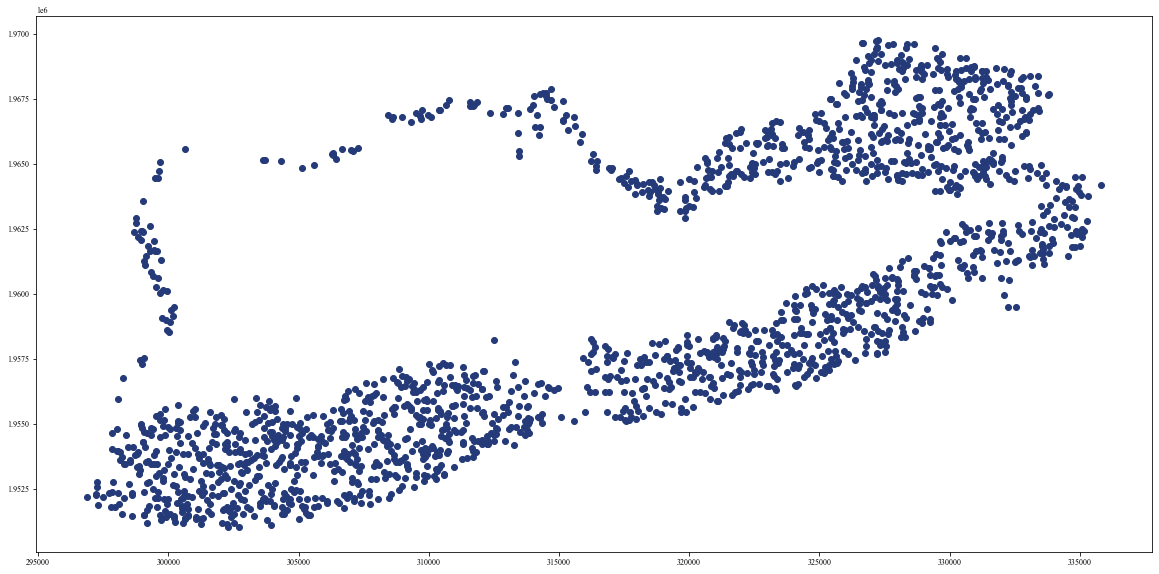

In [13]:
gdf_sampled = gpd.read_file("../data/truthraster_sampling/kriging_pts/")


ax = gdf_sampled.plot(figsize=(20, 12))
ax.get_figure().savefig("../document/figures/pts_sampled_from_truthraster.pdf")

In [14]:
bilinear_rmse = raster_RMSE_blocked(
    truth_raster_path=truthraster_path,
    measured_rasterpath="../data/truthraster_sampling/bilinear.tif",
)

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:172: RuntimeWarning: Mean of empty slice
  mse = np.nanmean(error_data**2)
/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:174: RuntimeWarning: Mean of empty slice
  mae = np.nanmean(np.abs(error_data))


In [15]:
assumed_gebco_variance = 1.5

In [18]:
purekriged_rmse = raster_RMSE_blocked(
    truth_raster_path=truthraster_path,
    measured_rasterpath="../data/truthraster_sampling/kriging_output.tif",
)
gridded_kalman_update(
    "../data/truthraster_sampling/kalman_update.tif",
    "../data/truthraster_sampling/bilinear.tif",
    "../data/truthraster_sampling/kriging_output.tif",
    1.5,
)
kalman_updated_rmse = raster_RMSE_blocked(
    truth_raster_path=truthraster_path,
    measured_rasterpath="../data/truthraster_sampling/kalman_update.tif",
)

[I 220927 00:31:00 kalman:72] Wrote Kalman Updated Raster with GEBCO uncertainty 1.5 to ../data/truthraster_sampling/kalman_update.tif


old val to beat: 2.358246

# sampling along lines

In [19]:
truthsampler = lambda x: query_from_lines(x, truthraster_path, 1)

In [20]:
sampled_lines = tracklines.geometry.apply(truthsampler).apply(pd.Series)

In [21]:
xvals = sampled_lines[0].apply(pd.Series).to_numpy().flatten()
yvals = sampled_lines[1].apply(pd.Series).to_numpy().flatten()
zvals = sampled_lines[2].apply(pd.Series).to_numpy().flatten()

In [22]:
points_along_lines = gpd.GeoDataFrame(
    zvals, geometry=gpd.points_from_xy(xvals, yvals), crs="EPSG:4326"
)
points_along_lines = points_along_lines.to_crs(points_along_lines.estimate_utm_crs())

In [23]:
# drop points where we have no value
points_along_lines = points_along_lines.rename(columns={0: "sf_elev_MSL"}).dropna()
# drop points on land
points_along_lines = points_along_lines[points_along_lines.sf_elev_MSL < 0]

In [24]:
points_along_lines.to_file("../data/truthraster_sampling/points_along_lines.gpkg")

/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [25]:
hres = 50
subset_gebco(
    "../data/truthraster_sampling",
    bathy_pts=points_along_lines,
    epsg_no=points_along_lines.crs.to_epsg(),
    hres=hres,
)

[D 220927 00:33:06 raster_interaction:149] GEBCO subset raster written to ../data/truthraster_sampling/bilinear.tif, with CRS EPSG:32620


In [26]:
# this is extremely ugly, but the kriging function requires a points path with this specific name
krige_bathy(
    kr_model="uk",
    folderpath="../data/truthraster_sampling",
    npts=2000,
    variogram_model="spherical",
    pts_gdf_all=points_along_lines,
    crs=points_along_lines.crs,
    samplemethod="dart",
    variogram_parameters={"range": 10000, "nugget": 0.7, "sill": 23},
)

[D 220927 00:33:06 kriging:29] The types of the numpy array that is sent to PDAL poisson dart throwing are: (numpy.record, [('Y', '<f8'), ('X', '<f8'), ('Z', '<f8')])
[D 220927 00:33:06 kriging:35] 2000 points remaining after relaxation dart throwing culling
/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
[D 220927 00:33:07 kriging:79] 2000 points selected with dart written to ../data/truthraster_sampling/kriging_pts


Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Partial Sill: 22.3
Full Sill: 23.0
Range: 10000
Nugget: 0.7 

Calculating statistics on variogram model fit...
Q1 = 0.005270822575576918
Q2 = 2.0583005799391185
cR = 3.5943491439933135 

Initializing drift terms...
Executing Universal Kriging...



[D 220927 00:35:52 kriging:134] finished kriging, now saving the output raster to ../data/truthraster_sampling/kriging_output.tif
[D 220927 00:35:52 kriging:152] Output raster of kriged Z values and uncertainty saved sucessfully


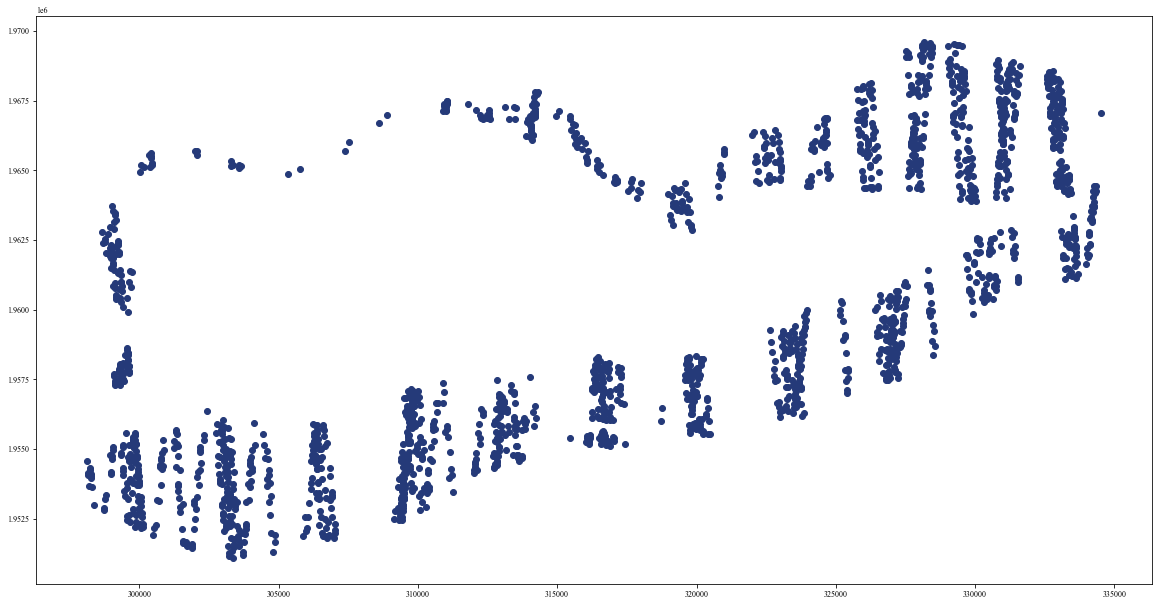

In [27]:
gdf_sampled = gpd.read_file("../data/truthraster_sampling/kriging_pts/")

ax = gdf_sampled.plot(figsize=(20, 12))
ax.get_figure().savefig("../document/figures/pts_sampled_from_truthraster.pdf")

In [28]:
purekriged_rmse_lines = raster_RMSE_blocked(
    truth_raster_path=truthraster_path,
    measured_rasterpath="../data/truthraster_sampling/kriging_output.tif",
)

gridded_kalman_update(
    "../data/truthraster_sampling/kalman_update.tif",
    "../data/truthraster_sampling/bilinear.tif",
    "../data/truthraster_sampling/kriging_output.tif",
    gebco_uncertainty_in=assumed_gebco_variance,
)
kalman_updated_rmse_lines = raster_RMSE_blocked(
    truth_raster_path=truthraster_path,
    measured_rasterpath="../data/truthraster_sampling/kalman_update.tif",
)

[I 220927 00:36:58 kalman:72] Wrote Kalman Updated Raster with GEBCO uncertainty 1.5 to ../data/truthraster_sampling/kalman_update.tif
/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:172: RuntimeWarning: Mean of empty slice
  mse = np.nanmean(error_data**2)
/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:174: RuntimeWarning: Mean of empty slice
  mae = np.nanmean(np.abs(error_data))


In [29]:
rmse_dict = {
    f"Truth vs {hres}m bilinear resampling of GEBCO": bilinear_rmse,
    "Truth vs Kriged raster output": purekriged_rmse,
    "Truth vs GEBCO+Kriged raster": kalman_updated_rmse,
    "Truth Vs kriged Raster - Sampling along lines": purekriged_rmse_lines,
    "Gebco updated - sampling along lines": kalman_updated_rmse_lines,
}
truthraster_sampling_table = pd.DataFrame.from_dict(rmse_dict, orient="columns").T

truthraster_sampling_table.style.to_latex(
    "../document/tables/truth_raster_sample_error.tex",
    caption="Error between the various data products",
    label="tab:rmse-truth-raster-sampled",
)

truthraster_sampling_table

,RMSE,MAE
Truth vs 50m bilinear resampling of GEBCO,6.383116,4.311068
Truth vs Kriged raster output,2.592699,1.508940
Truth vs GEBCO+Kriged raster,3.150718,2.172880
Truth Vs kriged Raster - Sampling along lines,4.565826,2.246766
Gebco updated - sampling along lines,3.552600,2.417099
